### Import Modules

In [2]:
import h2o
from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator 
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch 
from h2o.estimators.xgboost import H2OXGBoostEstimator
from h2o.estimators.stackedensemble import H2OStackedEnsembleEstimator
#import xgboost as xgb
h2o.init() # give h2o as much memory as possible
h2o.no_progress() # turn off h2o progress bars

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
import matplotlib.pyplot as plt
pd.options.display.mpl_style = 'default'
from pandas.tools.plotting import scatter_matrix

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,05 secs
H2O cluster version:,3.10.5.2
H2O cluster version age:,"7 days, 1 hour and 24 minutes"
H2O cluster name:,H2O_from_python_Soomin_g52lhq
H2O cluster total nodes:,1
H2O cluster free memory:,3.528 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"
H2O connection url:,http://localhost:54321
H2O connection proxy:,None


C:\Users\Soomin\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2881: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
%matplotlib inline

### Import Data & Create Sales Price Dummy Column in Test Dataset

In [4]:
trainori = h2o.import_file('train.csv')
testori = h2o.import_file('test.csv')

dummy_col = np.random.rand(testori.shape[0])
testori = testori.cbind(h2o.H2OFrame(dummy_col))
cols = testori.columns
cols[-1] = 'SalePrice'
testori.columns = cols
print(trainori.shape)
print(testori.shape)

(1460, 81)
(1459, 81)


### Split into train and validation.

In [5]:
trainori, validori = trainori.split_frame([0.7], seed=12345)
print(trainori.shape)
print(validori.shape)

(1001, 81)
(459, 81)


### [to-do] Correlation matrix & scatter plot (Dan)
* Fill here with Correlation matrix & scatter plot
* use https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python

# Preprocessing data

### Impute & encode variables.

#### Transform Data to Pandas and Summarize Missing Values 

In [6]:
def show_missing():
    missing = pandas_train.columns[pandas_train.isnull().any()].tolist()
    return missing

In [9]:
trainori

Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1,60,RL,65,8450,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NA,Attchd,2003,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NA,NA,NA,0,2,2008,WD,Normal,208500
2,20,RL,80,9600,Pave,NA,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NA,NA,NA,0,5,2007,WD,Normal,181500
3,60,RL,68,11250,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NA,NA,NA,0,9,2008,WD,Normal,223500
5,60,RL,84,14260,Pave,NA,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NA,NA,NA,0,12,2008,WD,Normal,250000
6,50,RL,85,14115,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,NA,Attchd,1993,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,NA,MnPrv,Shed,700,10,2009,WD,Normal,143000
7,20,RL,75,10084,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,NA,NA,NA,0,8,2007,WD,Normal,307000
9,50,RM,51,6120,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,NA,NA,NA,0,4,2008,WD,Abnorml,129900
11,20,RL,70,11200,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,1Fam,1Story,5,5,1965,1965,Hip,CompShg,HdBoard,HdBoard,None,0,TA,TA,CBlock,TA,TA,No,Rec,906,Unf,0,134,1040,GasA,Ex,Y,SBrkr,1040,0,0,1040,1,0,1,0,3,1,TA,5,Typ,0,NA,Detchd,1965,Unf,1,384,TA,TA,Y,0,0,0,0,0,0,NA,NA,NA,0,2,2008,WD,Normal,129500
12,60,RL,85,11924,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,2Story,9,5,2005,2006,Hip,CompShg,WdShing,Wd Shng,Stone,286,Ex,TA,PConc,Ex,TA,No,GLQ,998,Unf,0,177,1175,GasA,Ex,Y,SBrkr,1182,1142,0,2324,1,0,3,0,4,1,Ex,11,Typ,2,Gd,BuiltIn,2005,Fin,3,736,TA,TA,Y,147,21,0,0,0,0,NA,NA,NA,0,7,2006,New,Partial,345000
13,20,RL,nan,12968,Pave,NA,IR2,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,1Fam,1Story,5,6,1962,1962,Hip,CompShg,HdBoard,Plywood,None,0,TA,TA,CBlock,TA,TA,No,ALQ,737,Unf,0,175,912,GasA,TA,Y,SBrkr,912,0,0,912,1,0,1,0,2,1,TA,4,Typ,0,NA,Detchd,1962,Unf,1,352,TA,TA,Y,140,0,0,0,176,0,NA,NA,NA,0,9,2008,WD,Normal,144000


In [7]:
pandas_train = trainori.as_data_frame(use_pandas=True) #Convert to Pandas frame
pandas_train.isnull().any() #Check for missing values (TRUE = missing)
#pandas_vali = validori.as_data_frame(use_pandas=True)
#pandas_vali.isnull().any()

Id               False
MSSubClass       False
MSZoning         False
LotFrontage       True
LotArea          False
Street           False
Alley             True
LotShape         False
LandContour      False
Utilities        False
LotConfig        False
LandSlope        False
Neighborhood     False
Condition1       False
Condition2       False
BldgType         False
HouseStyle       False
OverallQual      False
OverallCond      False
YearBuilt        False
YearRemodAdd     False
RoofStyle        False
RoofMatl         False
Exterior1st      False
Exterior2nd      False
MasVnrType        True
MasVnrArea        True
ExterQual        False
ExterCond        False
Foundation       False
                 ...  
BedroomAbvGr     False
KitchenAbvGr     False
KitchenQual      False
TotRmsAbvGrd     False
Functional       False
Fireplaces       False
FireplaceQu       True
GarageType        True
GarageYrBlt       True
GarageFinish      True
GarageCars       False
GarageArea       False
GarageQual 

Same steps applied to test data

In [18]:
pandas_test = testori.as_data_frame(use_pandas=True) 
pandas_test.isnull().any() 

Id               False
MSSubClass       False
MSZoning          True
LotFrontage       True
LotArea          False
Street           False
Alley             True
LotShape         False
LandContour      False
Utilities         True
LotConfig        False
LandSlope        False
Neighborhood     False
Condition1       False
Condition2       False
BldgType         False
HouseStyle       False
OverallQual      False
OverallCond      False
YearBuilt        False
YearRemodAdd     False
RoofStyle        False
RoofMatl         False
Exterior1st       True
Exterior2nd       True
MasVnrType        True
MasVnrArea        True
ExterQual        False
ExterCond        False
Foundation       False
                 ...  
BedroomAbvGr     False
KitchenAbvGr     False
KitchenQual       True
TotRmsAbvGrd     False
Functional        True
Fireplaces       False
FireplaceQu       True
GarageType        True
GarageYrBlt       True
GarageFinish      True
GarageCars        True
GarageArea        True
GarageQual 

In [10]:
pandas_train.describe()

C:\Users\Soomin\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1001.000000,1001.000000,822.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,994.000000,1001.000000,...,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000
mean,724.829171,57.087912,70.599757,10628.262737,6.144855,5.583417,1972.298701,1985.138861,106.911469,445.599401,...,91.073926,44.924076,21.257742,3.456543,14.763237,3.376623,39.684316,6.362637,2007.828172,182171.959041
std,421.495494,42.221277,25.107499,9442.373107,1.353512,1.088708,29.873026,20.606836,180.072510,467.173266,...,120.050442,63.018745,61.044422,29.836058,54.169815,43.987919,516.249355,2.676820,1.316984,80367.946180
min,1.000000,20.000000,21.000000,1300.000000,2.000000,2.000000,1875.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,364.000000,20.000000,NaN,7560.000000,5.000000,5.000000,1955.000000,1967.000000,NaN,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,130000.000000
50%,727.000000,50.000000,NaN,9587.000000,6.000000,5.000000,1975.000000,1994.000000,NaN,388.000000,...,0.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,165000.000000
75%,1081.000000,70.000000,NaN,11751.000000,7.000000,6.000000,2001.000000,2004.000000,NaN,716.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,215000.000000
max,1460.000000,190.000000,313.000000,164660.000000,10.000000,9.000000,2010.000000,2010.000000,1378.000000,5644.000000,...,736.000000,523.000000,552.000000,508.000000,440.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


### [To-do] Analysis on each variable having 'NA's

1. LotFrontage: Group by neighborhood for linear feet of street connected to property and fill NA using the median of each group [soomin]

In [20]:
pandas_train.groupby('Neighborhood', as_index=False)['LotFrontage'].mean()

,Neighborhood,LotFrontage
0,Blmngtn,47.142857
1,Blueste,24.000000
2,BrDale,21.562500
3,BrkSide,57.509804
4,ClearCr,83.461538
5,CollgCr,71.682540
6,Crawfor,71.804878
7,Edwards,68.217391
8,Gilbert,79.877551
9,IDOTRR,62.500000


In [11]:
train_df = pd.DataFrame()
train_df["LotFrontage"] = pandas_train["LotFrontage"]   
for key, group in lot_frontage_by_neighborhood:
    idx = (pandas_train["Neighborhood"] == key) & (pandas_train["LotFrontage"].isnull())
    train_df.loc[idx, "LotFrontage"] = group.median()

NameError: name 'lot_frontage_by_neighborhood' is not defined

(2) Alley 

In [13]:
train_df["Alley"] = pandas_train["Alley"].fillna("None", inplace=True)

In [14]:
pandas_train["Alley"].describe()

count     1001
unique       3
top       None
freq       942
Name: Alley, dtype: object

(3) MasVnrType and MasVnrArea: Replace "missing" with "none" and 0
--> We can do it using most frequent values (Rong)

In [15]:
pandas_train[['MasVnrType','MasVnrArea']][pandas_train['MasVnrType'].isnull()==True]

,MasVnrType,MasVnrArea
163,NaN,NaN
371,NaN,NaN
446,NaN,NaN
646,NaN,NaN
672,NaN,NaN
676,NaN,NaN
855,NaN,NaN


In [16]:
train_df["MasVnrType"] = pandas_train["MasVnrType"].fillna("None", inplace=True)
train_df["MasVnrArea"] = pandas_train["MasVnrArea"].fillna(0, inplace=True)
pandas_train[['MasVnrType','MasVnrArea']][pandas_train['MasVnrType'].isnull()==True]

,MasVnrType,MasVnrArea


(4) 'BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','BsmtFinSF1','BsmtFinSF2' (related to basement) (Rong)
* check all the variables below have NAs

In [17]:
basement_cols=['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','BsmtFinSF1','BsmtFinSF2']
pandas_train[basement_cols][pandas_train['BsmtQual'].isnull()==True]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtFinSF1,BsmtFinSF2
12,NaN,NaN,NaN,NaN,NaN,0,0
28,NaN,NaN,NaN,NaN,NaN,0,0
65,NaN,NaN,NaN,NaN,NaN,0,0
72,NaN,NaN,NaN,NaN,NaN,0,0
109,NaN,NaN,NaN,NaN,NaN,0,0
128,NaN,NaN,NaN,NaN,NaN,0,0
179,NaN,NaN,NaN,NaN,NaN,0,0
235,NaN,NaN,NaN,NaN,NaN,0,0
249,NaN,NaN,NaN,NaN,NaN,0,0
255,NaN,NaN,NaN,NaN,NaN,0,0


In [18]:
train_df["BsmtQual"] = pandas_train["BsmtQual"].fillna("None", inplace=True)
train_df["BsmtCond"] = pandas_train["BsmtCond"].fillna("None", inplace=True)
train_df["BsmtExposure"] = pandas_train["BsmtExposure"].fillna("None", inplace=True)
train_df["BsmtFinType1"] = pandas_train["BsmtFinType1"].fillna("None", inplace=True)
train_df["BsmtFinSF1"] = pandas_train["BsmtFinSF1"].fillna(0, inplace=True)
train_df["BsmtFinType2"] = pandas_train["BsmtFinType2"].fillna("None", inplace=True)
train_df["BsmtFinSF2"] = pandas_train["BsmtFinSF2"].fillna(0, inplace=True)
train_df["BsmtUnfSF"] = pandas_train["BsmtUnfSF"].fillna(0, inplace=True)

In [19]:
pandas_train[basement_cols][pandas_train['BsmtQual'].isnull()==True]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtFinSF1,BsmtFinSF2


(5) Electrical : There is NA, but only one value --> fill it with the most frequent value 

In [ ]:
pandas_train['Electrical'].describe()

In [ ]:
train_df["Electrical"] = pandas_train["Electrical"].fillna("SBrkr", inplace=True)

In [ ]:
pandas_train['Electrical'].describe()

(6) FireplaceQu: Replace "missing" with "None"

In [ ]:
train_df["FireplaceQu"] = pandas_train["FireplaceQu"].fillna("None", inplace=True)

In [ ]:
pd.crosstab(pandas_train["Fireplaces"], pandas_train["FireplaceQu"])

(7) "Garage" Variables: Replace "missing" with "none" and 0 

In [ ]:
garage_cols=['GarageType','GarageQual','GarageCond','GarageYrBlt','GarageFinish','GarageCars','GarageArea']
pandas_train[garage_cols][pandas_train['GarageType'].isnull()==True]

In [ ]:
train_df["GarageType"] = pandas_train["GarageType"].fillna("None", inplace=True)
train_df["GarageQual"] = pandas_train["GarageQual"].fillna("None", inplace=True)
train_df["GarageCond"] = pandas_train["GarageCond"].fillna("None", inplace=True)
#train_df["GarageYrBlt"] = pandas_train["GarageYrBlt"].fillna(0, inplace=True)
train_df["GarageFinish"] = pandas_train["GarageFinish"].fillna("None", inplace=True)
train_df["GarageCars"] = pandas_train["GarageCars"].fillna(0, inplace=True)
train_df["GarageArea"] = pandas_train["GarageArea"].fillna(0, inplace=True)

[To-do] Deal with 'GarageYrBlt' (let's search for why we should do binning) (Rong)
* NA --> 'none'
* before 1960 (or 1980) --> 'bf1960'
* 1961~1970 --> '1960'
* 1971~1980 --> '1980'
...

In [21]:
plotdata=trainori.as_data_frame(use_pandas=True)
plotdatatest=testori.as_data_frame(use_pandas=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000024DEA74D898>]], dtype=object)

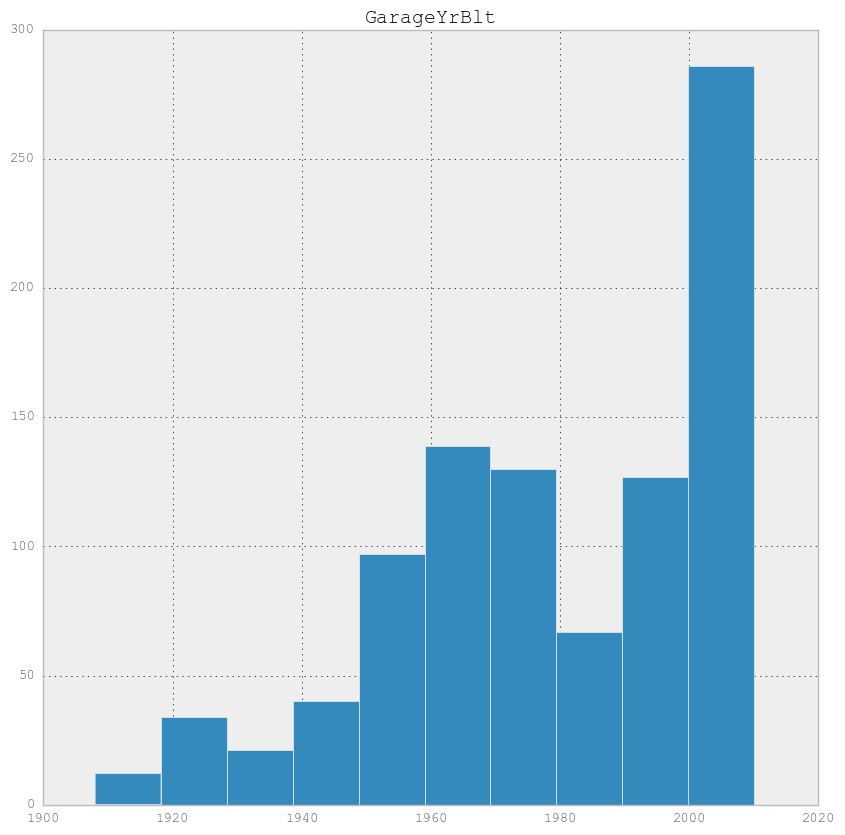

In [23]:
plotdata.iloc[:,59:60].hist(figsize=(10,10))

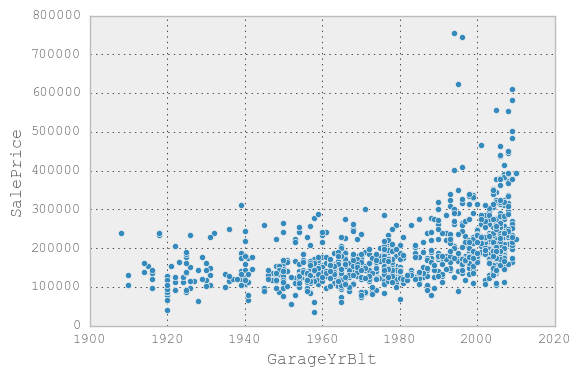

In [25]:
var = 'GarageYrBlt'
data = pd.concat([pandas_train['SalePrice'], pandas_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

In [ ]:
garage_cols=['GarageType','GarageQual','GarageCond','GarageYrBlt','GarageFinish','GarageCars','GarageArea']
pandas_train[garage_cols][pandas_train['GarageType'].isnull()==True]

(8) PoolQC: Replace "missing" with "none"

In [26]:
pd.crosstab(pandas_train["PoolArea"], pandas_train["PoolQC"])

PoolQC,Ex,Fa,Gd
PoolArea,,,
480,0,0,1
512,1,0,0
519,0,1,0
555,1,0,0
576,0,0,1
738,0,0,1


In [27]:
train_df["PoolQC"] = pandas_train["PoolQC"].fillna("None", inplace=True)

In [28]:
pd.crosstab(pandas_train["PoolArea"], pandas_train["PoolQC"])

PoolQC,Ex,Fa,Gd,None
PoolArea,,,,
0,0,0,0,995
480,0,0,1,0
512,1,0,0,0
519,0,1,0,0
555,1,0,0,0
576,0,0,1,0
738,0,0,1,0


(9) Fence and MiscFeature: Replace "missing" with "none"

In [29]:
train_df["Fence"] = pandas_train["Fence"].fillna("None", inplace=True)
train_df["MiscFeature"] = pandas_train["MiscFeature"].fillna("None", inplace=True)

11. Check for Missing

In [30]:
pandas_train[show_missing()].isnull().sum()

LotFrontage     179
Electrical        1
FireplaceQu     466
GarageType       48
GarageYrBlt      48
GarageFinish     48
GarageQual       48
GarageCond       48
dtype: int64

12. Feature-Engineer Categorical Variables

[To-do] Deal with the other Year variables : YearBuilt, YearRemodAdd, YrSold


[Let's not to run below codes for encoding.. Just let categorical variables categorical]
[Let's think to do target encoding instead]

In [ ]:
quality_dict = {"None": 0, "Fa": 1, "Gd": 2, "Ex": 3}

train_df["PoolQC"] = pandas_train["PoolQC"].map(quality_dict).astype(int)

In [ ]:
quality_dict = {"None": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}

train_df["BsmtQual"] = pandas_train["BsmtQual"].map(quality_dict).astype(int)
train_df["BsmtCond"] = pandas_train["BsmtCond"].map(quality_dict).astype(int)
train_df["FireplaceQu"] = pandas_train["FireplaceQu"].map(quality_dict).astype(int)
train_df["GarageQual"] = pandas_train["GarageQual"].map(quality_dict).astype(int)
train_df["GarageCond"] = pandas_train["GarageCond"].map(quality_dict).astype(int)

In [ ]:
quality_dict = {None: 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}

train_df["ExterQual"] = pandas_train["ExterQual"].map(quality_dict).astype(int)
train_df["ExterCond"] = pandas_train["ExterCond"].map(quality_dict).astype(int)
train_df["HeatingQC"] = pandas_train["HeatingQC"].map(quality_dict).astype(int)
train_df["KitchenQual"] = pandas_train["KitchenQual"].map(quality_dict).astype(int)

------------------------------------------------------------------------------ [until here]

[to-do] Apply Target encoding on the data after preprocessing (Soomin)

In [ ]:
train_new = h2o.H2OFrame(pandas_train) #Convert back to H2O frame 

[to-do] Set real categorical variables as categorical using h20.asfactor() looking through train.xlsx (Rong)

Next - Combine Features

In [17]:
original_nums, cats = get_type_lists()

Numeric = ['BsmtFullBath', 'GarageYrBlt', 'LowQualFinSF', 'YearRemodAdd', 'MSSubClass', 'GarageCars', 'LotFrontage', 'BsmtUnfSF', 'Fireplaces', 'BsmtFinSF2', 'FullBath', 'YrSold', 'MoSold', 'GarageArea', 'BsmtFinSF1', 'OpenPorchSF', 'OverallQual', 'YearBuilt', 'EnclosedPorch', 'WoodDeckSF', 'BsmtHalfBath', '3SsnPorch', 'KitchenAbvGr', 'MasVnrArea', 'PoolArea', 'LotArea', 'HalfBath', 'ScreenPorch', 'GrLivArea', 'OverallCond', 'TotalBsmtSF', '1stFlrSF', 'BedroomAbvGr', 'TotRmsAbvGrd', 'MiscVal', '2ndFlrSF']

Categorical = ['Utilities', 'LandContour', 'Exterior1st', 'LandSlope', 'Neighborhood', 'HeatingQC', 'Condition2', 'Electrical', 'Fence', 'MasVnrType', 'LotConfig', 'LotShape', 'FireplaceQu', 'RoofMatl', 'SaleType', 'GarageCond', 'SaleCondition', 'ExterCond', 'PoolQC', 'BsmtExposure', 'Exterior2nd', 'BsmtFinType1', 'HouseStyle', 'GarageQual', 'GarageType', 'Heating', 'RoofStyle', 'KitchenQual', 'BldgType', 'Functional', 'Foundation', 'Street', 'ExterQual', 'CentralAir', 'BsmtCond', 'M

[to-do] think about GLRM imputing below... should we do that or not? (Soomin & Rong & Dan)

### Impute Missing Values for Numeric Variables via Generalized Low Rank Model

In [18]:
def glrm_num_impute(role, frame):

    """ Helper function for imputing numeric variables using GLRM.
    
    :param role: Role of frame to be imputed.
    :param frame: H2OFrame to be imputed.
    :return: H2OFrame of imputed numeric features.
    
    """
    
    # count missing values in training data numeric columns
    print(role + ' missing:\n', [cnt for cnt in frame.nacnt() if cnt != 0.0])

    # initialize GLRM
    matrix_complete_glrm = H2OGeneralizedLowRankEstimator(
        k=10,                    # create 10 features 
        transform='STANDARDIZE', # <- seems very important
        gamma_x=0.001,           # regularization on values in X
        gamma_y=0.05)            # regularization on values in Y

    # train GLRM`
    matrix_complete_glrm.train(training_frame=frame, x=original_nums)

    # plot iteration history to ensure convergence
    matrix_complete_glrm.score_history().plot(x='iteration', y='objective', title='GLRM Score History')

    # impute numeric inputs by multiply the calculated xi and yj for the missing values in train
    num_impute = matrix_complete_glrm.predict(frame)

    # count missing values in imputed set
    print('imputed ' + role + ' missing:\n', [cnt for cnt in num_impute.nacnt() if cnt != 0.0])
    
    return num_impute

train missing:
 [1369.0, 8.0, 38.0, 37.0, 38.0, 1.0, 690.0, 81.0, 81.0, 81.0, 81.0, 1453.0, 1179.0, 1406.0]
imputed train missing:
 []


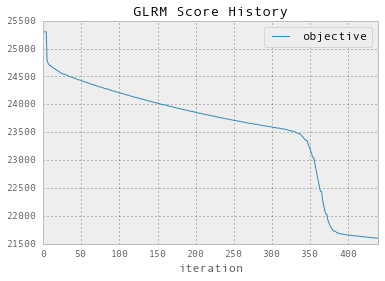

In [19]:
train_new_nums = glrm_num_impute('train', train)

test missing:
 [1352.0, 16.0, 44.0, 42.0, 1.0, 42.0, 1.0, 1.0, 1.0, 2.0, 2.0, 730.0, 76.0, 78.0, 1.0, 1.0, 78.0, 78.0, 1456.0, 1169.0, 1408.0]
imputed test missing:
 []


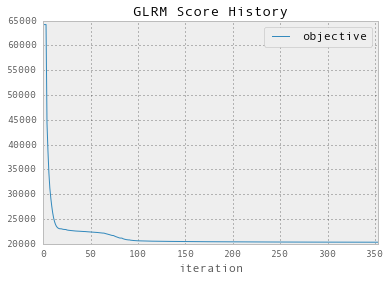

In [30]:
test_nums_new = glrm_num_impute('test', test)

In [31]:
print(train_new_nums.shape)
print(test_nums_new.shape)

(1460, 36)
(1459, 36)


Checking the result of imputation

In [21]:
pandas_train_new_nums = train_new_nums.as_data_frame(use_pandas=True)
pandas_train_new_nums.isnull().any()

reconstr_MSSubClass       False
reconstr_LotFrontage      False
reconstr_LotArea          False
reconstr_OverallQual      False
reconstr_OverallCond      False
reconstr_YearBuilt        False
reconstr_YearRemodAdd     False
reconstr_MasVnrArea       False
reconstr_BsmtFinSF1       False
reconstr_BsmtFinSF2       False
reconstr_BsmtUnfSF        False
reconstr_TotalBsmtSF      False
reconstr_1stFlrSF         False
reconstr_2ndFlrSF         False
reconstr_LowQualFinSF     False
reconstr_GrLivArea        False
reconstr_BsmtFullBath     False
reconstr_BsmtHalfBath     False
reconstr_FullBath         False
reconstr_HalfBath         False
reconstr_BedroomAbvGr     False
reconstr_KitchenAbvGr     False
reconstr_TotRmsAbvGrd     False
reconstr_Fireplaces       False
reconstr_GarageYrBlt      False
reconstr_GarageCars       False
reconstr_GarageArea       False
reconstr_WoodDeckSF       False
reconstr_OpenPorchSF      False
reconstr_EnclosedPorch    False
reconstr_3SsnPorch        False
reconstr

### Explore the input variables. 
[to-do] move this part to the beginning of this notebook (Rong)

In [20]:
plotdata=train.as_data_frame(use_pandas=True)
plotdatatest=test.as_data_frame(use_pandas=True)

NameError: name 'train' is not defined

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x117717d68>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x117ee6208>]], dtype=object)

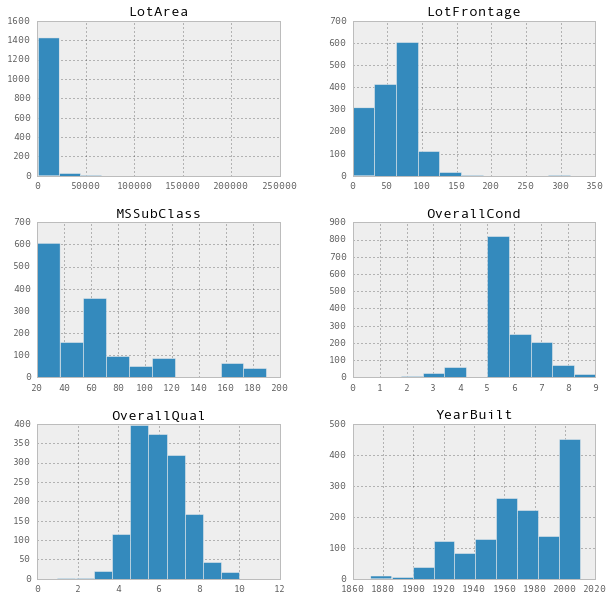

In [33]:
plotdata.iloc[:,1:20].hist(figsize=(10,10))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x118401048>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11b3965f8>]], dtype=object)

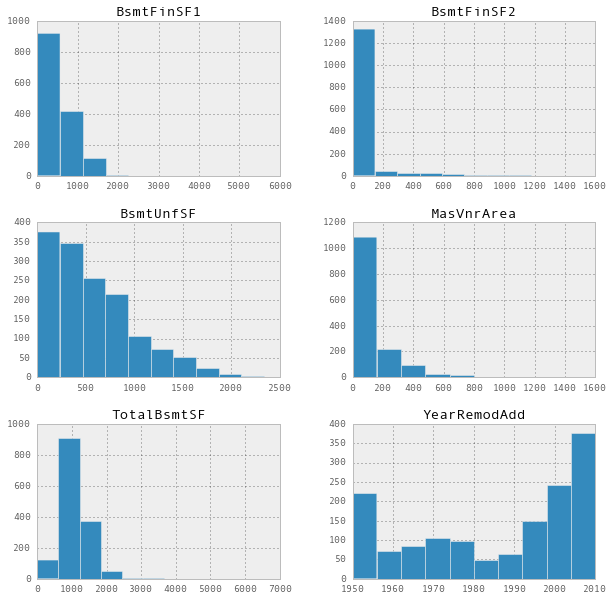

In [34]:
plotdata.iloc[:,20:40].hist(figsize=(10,10))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11b3a9978>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11c1fada0>]], dtype=object)

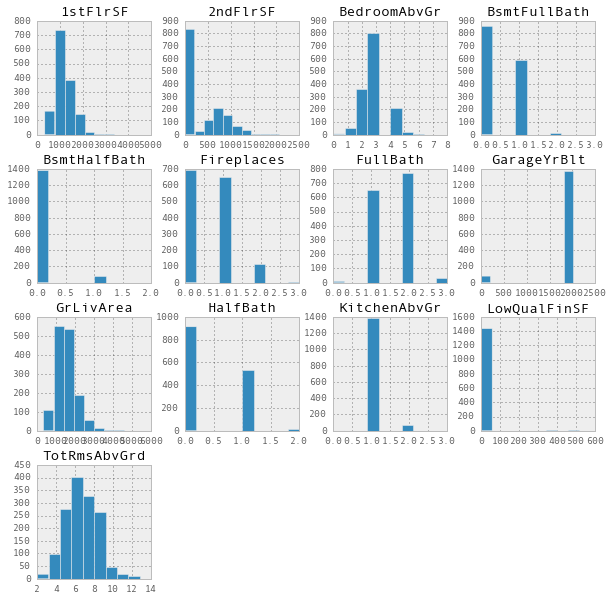

In [35]:
plotdata.iloc[:,40:60].hist(figsize=(10,10))

#### As we can see from the distributions of numerical variables, some are having outliers issue and majority is not normal distributed, which indicates standardization

//anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2885: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

  exec(code_obj, self.user_global_ns, self.user_ns)


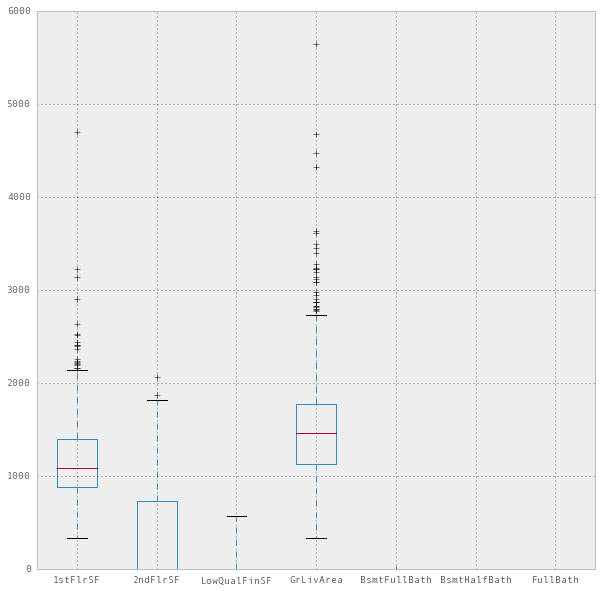

In [36]:
pd.options.display.mpl_style = 'default'
plotdata.iloc[:,40:50].plot(kind='box',figsize=(10,10))

//anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2885: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

  exec(code_obj, self.user_global_ns, self.user_ns)


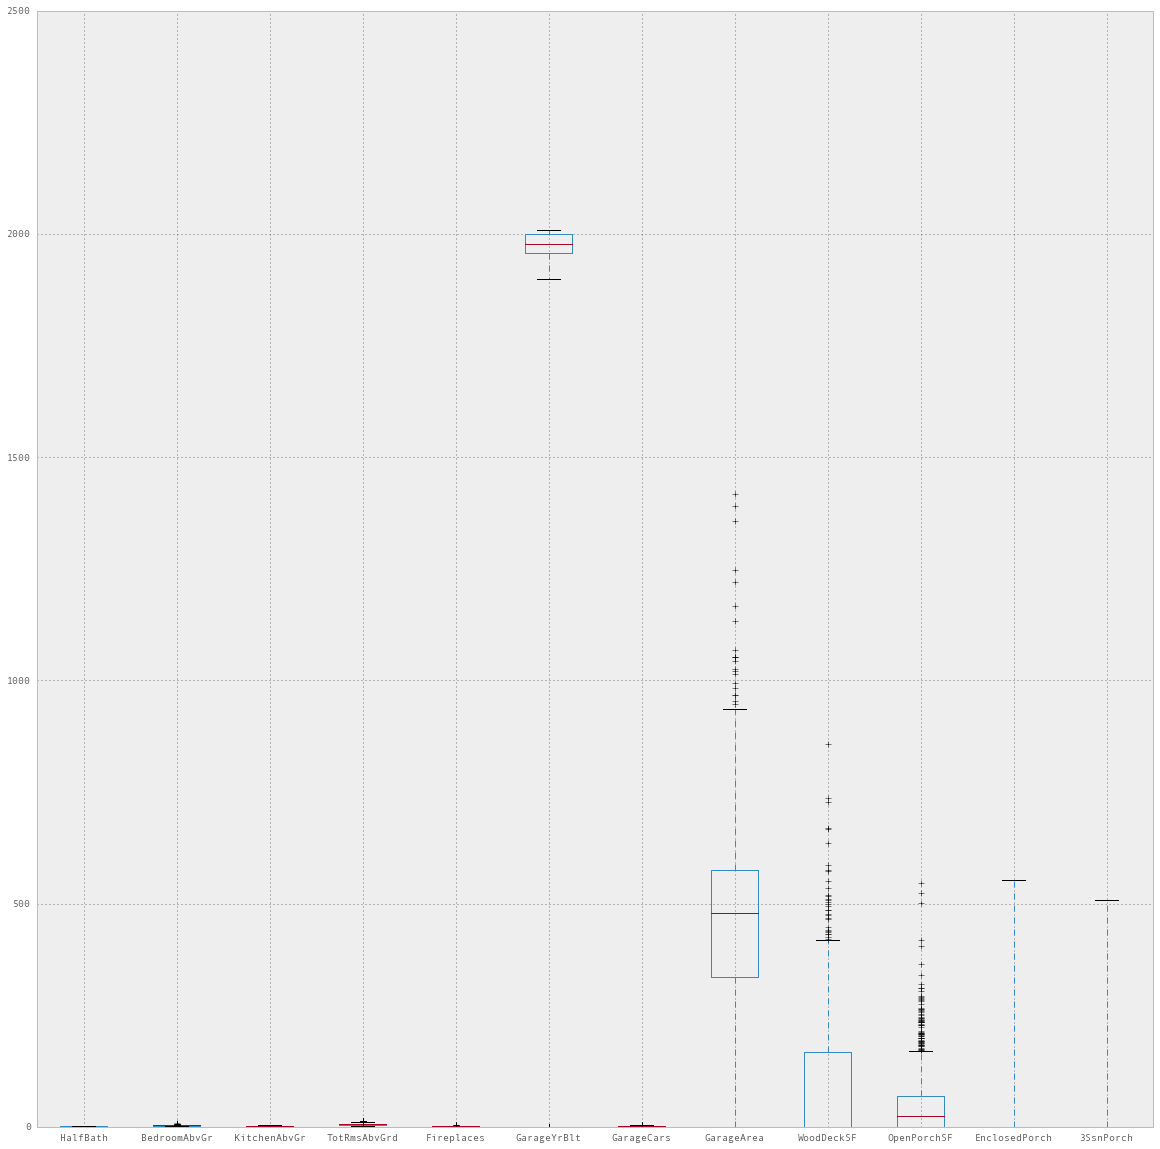

In [37]:
pd.options.display.mpl_style = 'default'
plotdata.iloc[:,50:70].plot(kind='box',figsize=(20,20))

//anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2885: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

  exec(code_obj, self.user_global_ns, self.user_ns)


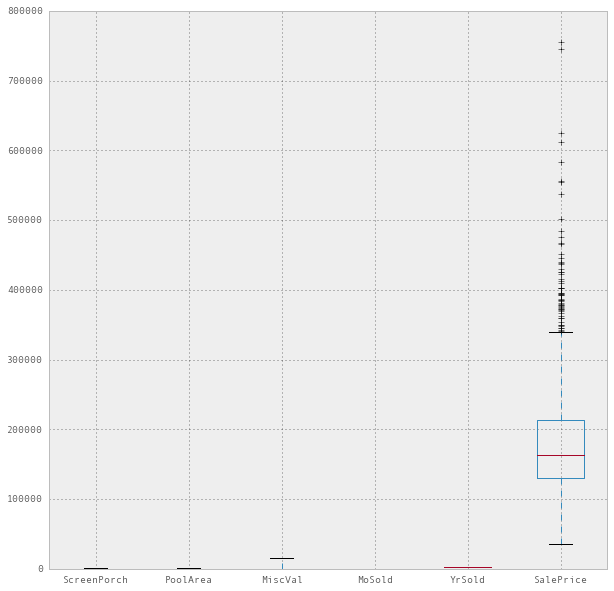

In [38]:
pd.options.display.mpl_style = 'default'
plotdata.iloc[:,70:81].plot(kind='box',figsize=(10,10))

Using box plot to identify thoes variables that have outlier issue.

### Winsorize Varaiables that have outliers issue.

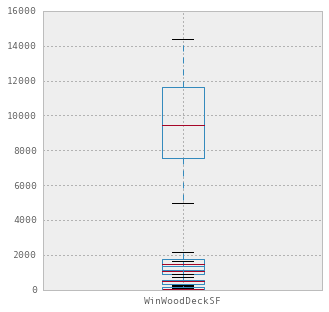

In [39]:
plotdata['WinLotArea']=winsorize(plotdata['LotArea'],limits=[0.1,0.1])
plotdata['WinLotArea'].plot(kind='box',figsize=(5,5))
plotdata['Win1stFlrSF']=winsorize(plotdata['1stFlrSF'],limits=[0.1,0.1])
plotdata['Win1stFlrSF'].plot(kind='box',figsize=(5,5))
plotdata['WinGarageArea']=winsorize(plotdata['GarageArea'],limits=[0.1,0.1])
plotdata['WinGarageArea'].plot(kind='box',figsize=(5,5))
plotdata['WinGrLivArea']=winsorize(plotdata['GrLivArea'],limits=[0.1,0.1])
plotdata['WinGrLivArea'].plot(kind='box',figsize=(5,5))
plotdata['WinOpenPorchSF']=winsorize(plotdata['OpenPorchSF'],limits=[0.1,0.1])
plotdata['WinOpenPorchSF'].plot(kind='box',figsize=(5,5))
plotdata['WinWoodDeckSF']=winsorize(plotdata['WoodDeckSF'],limits=[0.1,0.1])
plotdata['WinWoodDeckSF'].plot(kind='box',figsize=(5,5))

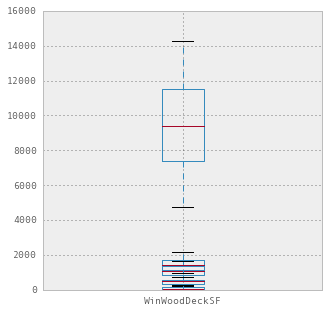

In [40]:
plotdatatest['WinLotArea']=winsorize(plotdatatest['LotArea'],limits=[0.1,0.1])
plotdatatest['WinLotArea'].plot(kind='box',figsize=(5,5))
plotdatatest['Win1stFlrSF']=winsorize(plotdatatest['1stFlrSF'],limits=[0.1,0.1])
plotdatatest['Win1stFlrSF'].plot(kind='box',figsize=(5,5))
plotdatatest['WinGarageArea']=winsorize(plotdatatest['GarageArea'],limits=[0.1,0.1])
plotdatatest['WinGarageArea'].plot(kind='box',figsize=(5,5))
plotdatatest['WinGrLivArea']=winsorize(plotdatatest['GrLivArea'],limits=[0.1,0.1])
plotdatatest['WinGrLivArea'].plot(kind='box',figsize=(5,5))
plotdatatest['WinOpenPorchSF']=winsorize(plotdatatest['OpenPorchSF'],limits=[0.1,0.1])
plotdatatest['WinOpenPorchSF'].plot(kind='box',figsize=(5,5))
plotdatatest['WinWoodDeckSF']=winsorize(plotdatatest['WoodDeckSF'],limits=[0.1,0.1])
plotdatatest['WinWoodDeckSF'].plot(kind='box',figsize=(5,5))

In [41]:
plotdata.drop(['WoodDeckSF','OpenPorchSF','GrLivArea','GarageArea','1stFlrSF','LotArea'],axis=1,inplace=True)
plotdatatest.drop(['WoodDeckSF','OpenPorchSF','GrLivArea','GarageArea','1stFlrSF','LotArea'],axis=1,inplace=True)

Get the list of numerical variables as well as categorical variables.

In [42]:
plttr=h2o.H2OFrame(plotdata)

In [43]:
def get_type_lists(frame=plttr, rejects=['Id', 'SalePrice']):

    """Creates lists of numeric and categorical variables.
    :param frame: The frame from which to determine types.
    :param rejects: Variable names not to be included in returned lists.
    :return: Tuple of lists for numeric and categorical variables in the frame.
    """
    
    nums, cats = [], []
    for key, val in frame.types.items():
        if key not in rejects:
            if val == 'enum':
                cats.append(key)
            else: 
                nums.append(key)
                
    print('Numeric =', nums)                
    print()
    print('Categorical =', cats)
    
    return nums, cats

In [44]:
original_nums, cats = get_type_lists()

Numeric = ['BsmtFullBath', 'GarageYrBlt', 'LowQualFinSF', 'MSSubClass', 'GarageCars', 'LotFrontage', 'YearRemodAdd', 'BsmtUnfSF', 'WinGarageArea', 'Fireplaces', 'BsmtFinSF2', 'FullBath', 'YrSold', 'MoSold', 'BsmtFinSF1', 'WinLotArea', 'OverallQual', 'YearBuilt', 'EnclosedPorch', 'WinGrLivArea', 'BsmtHalfBath', '3SsnPorch', 'WinWoodDeckSF', 'KitchenAbvGr', 'MasVnrArea', 'HalfBath', 'ScreenPorch', 'PoolArea', 'Win1stFlrSF', 'OverallCond', 'TotalBsmtSF', 'WinOpenPorchSF', 'BedroomAbvGr', 'TotRmsAbvGrd', 'MiscVal', '2ndFlrSF']

Categorical = ['Utilities', 'LandContour', 'HeatingQC', 'Exterior1st', 'LandSlope', 'Neighborhood', 'Condition2', 'Electrical', 'Fence', 'MasVnrType', 'LotConfig', 'LotShape', 'FireplaceQu', 'RoofMatl', 'SaleType', 'GarageCond', 'SaleCondition', 'ExterCond', 'PoolQC', 'BsmtExposure', 'Exterior2nd', 'BsmtFinType1', 'HouseStyle', 'GarageQual', 'GarageType', 'BsmtFinType2', 'Heating', 'RoofStyle', 'KitchenQual', 'BldgType', 'Functional', 'Foundation', 'Street', 'ExterQ

### Standardize numerical input variables 
[to-do] let's apply this on the data after preprocessing

In [ ]:
_tr = plotdata.copy()
_ts = plotdatatest.copy()

for col_name in original_nums:
    new_col_name = col_name + '_std'
    _tr[new_col_name] = (plotdata[col_name] - plotdata[col_name].mean())/plotdata[col_name].std()
    _ts[new_col_name] = (plotdatatest[col_name] - plotdatatest[col_name].mean())/plotdatatest[col_name].std()

Delete the original numerical variables.

In [47]:
for col_name in original_nums:
    del _tr[col_name]
    del _ts[col_name]

### Convert back to h2o

In [48]:
train=h2o.H2OFrame(_tr)
test=h2o.H2OFrame(_ts)

Checking the train and test data frame before next data preparation step.

In [49]:
train.describe()
print('--------------------------------------------------------------')
test.describe()

Rows:1460
Cols:81




,Id,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,SalePrice,BsmtFullBath_std,GarageYrBlt_std,LowQualFinSF_std,MSSubClass_std,GarageCars_std,LotFrontage_std,YearRemodAdd_std,BsmtUnfSF_std,WinGarageArea_std,Fireplaces_std,BsmtFinSF2_std,FullBath_std,YrSold_std,MoSold_std,BsmtFinSF1_std,WinLotArea_std,OverallQual_std,YearBuilt_std,EnclosedPorch_std,WinGrLivArea_std,BsmtHalfBath_std,3SsnPorch_std,WinWoodDeckSF_std,KitchenAbvGr_std,MasVnrArea_std,HalfBath_std,ScreenPorch_std,PoolArea_std,Win1stFlrSF_std,OverallCond_std,TotalBsmtSF_std,WinOpenPorchSF_std,BedroomAbvGr_std,TotRmsAbvGrd_std,MiscVal_std,2ndFlrSF_std
type,int,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,int,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real
mins,1.0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,34900.0,-0.8196835076441235,-4.118913083719189,-0.12020053800860489,-0.8722638821913684,-2.364629726102377,-1.6623235039534479,-1.6887898479984367,-1.2837357583879423,-1.4573645983861474,-0.9509006699369512,-0.2885539604701581,-2.8408488002532493,-1.367186277969802,-1.9684369798472843,-0.9726849003236182,-1.6137835102781273,-3.6871495308555806,-3.2866974672174027,-0.3592018228542554,-1.4198442469135284,-0.24097846650905574,-0.11629943710230208,-0.8460582455525355,-4.7498588539862086,-0.5705546379230072,-0.7613597983235844,-0.27011580124313217,-0.06866821893757184,-1.2767993865689162,-4.111561100736463,-2.4103410492171595,-0.8615456849657631,-3.5137478591635483,-2.7795169608179364,-0.08765777630136591,-0.7948908644380643
mean,730.5,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,180921.1958904111,1.1145598333150986e-16,1.5287250632045613e-16,-1.3227266504323154e-17,-4.824699667560495e-17,9.69276742202041e-17,1.0245710529988017e-16,4.529146155340946e-15,-4.846383711010205e-17,-3.924811864397526e-17,-7.296680620827445e-17,2.168404344971009e-18,1.4864411784776266e-16,3.565478804128802e-14,1.2727178252264215e-16,-2.862293735361732e-17,1.3308581667259567e-17,1.2110538266663085e-16,1.0333530905959343e-15,2.5261910618912253e-17,-1.4127154307486123e-16,5.7462715141731735e-18,1.9353008778866254e-17,-1.1427490897997217e-16,3.638582490861353e-16,-3.800128614561693e-17,7.426784881525705e-17,5.827586677109586e-18,8.461520329891559e-17,2.3979841549948144e-16,3.688997891881929e-16,2.470354650008222e-16,-8.950088933867839e-17,2.0086200498009577e-16,-8.17217387510949e-17,-1.0232158002831948e-18,1.7780915628762273e-17
maxs,1460.0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,755000.0,4.961659106657423,0.31135357298386057,11.643759769239269,3.1465943981111675,2.9878654678657943,7.3671379822779395,1.2174255905655946,4.0029234317160105,1.7413976687797907,3.7026690890841056,8.848605997891852,2.604629425177486,1.6446461865129791,2.1001727880223924,11.40184617827387,1.6836882246810223,2.820458909096378,1.2823995906581556,8.672337598563447,1.6885992954629354,8.135892035948595,17.211335458445188,1.8052685073148371,8.865574248408814,8.282363205121175,3.2156895954239406,8.338604627661638,18.299909869656002,1.7396033780210731,3.077515793964418,11.51700302286161,1.9677395771025776,6.292841148012138,4.603311594902235,31.15459310882023,3.9356142533042577
sigma,421.6100093688479,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,79442.50288288663,1.0000000000000149,0.9999999999999998,1.0000000000000229,1.000000000000003,0.9999

--------------------------------------------------------------
Rows:1459
Cols:81




,Id,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,SalePrice,BsmtFullBath_std,GarageYrBlt_std,LowQualFinSF_std,MSSubClass_std,GarageCars_std,LotFrontage_std,YearRemodAdd_std,BsmtUnfSF_std,WinGarageArea_std,Fireplaces_std,BsmtFinSF2_std,FullBath_std,YrSold_std,MoSold_std,BsmtFinSF1_std,WinLotArea_std,OverallQual_std,YearBuilt_std,EnclosedPorch_std,WinGrLivArea_std,BsmtHalfBath_std,3SsnPorch_std,WinWoodDeckSF_std,KitchenAbvGr_std,MasVnrArea_std,HalfBath_std,ScreenPorch_std,PoolArea_std,Win1stFlrSF_std,OverallCond_std,TotalBsmtSF_std,WinOpenPorchSF_std,BedroomAbvGr_std,TotRmsAbvGrd_std,MiscVal_std,2ndFlrSF_std
type,int,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real
mins,1461.0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,0.004435016315083029,-0.8187249144400626,-4.1993001696780725,-0.08045552704190534,-0.8744109900669876,-2.2760863307763786,-1.7947720666419749,-1.5930922337962812,-1.2676538185831319,-1.4276706002600457,-0.8977473772262465,-0.2976982900287009,-2.829552614642909,-1.3594919680629625,-1.8748608343548452,-0.9647145488047963,-1.6283229027361972,-3.534785609530218,-3.039077460386211,-0.36061465362326717,-1.3734213933017212,-0.2582600690930742,-0.08879620764046937,-0.8450603977266182,-5.000654760069599,-0.5631228262981368,-0.750782123198182,-0.30143966012116136,-0.057207322445492294,-1.3041679409200522,-4.0887510526488935,-2.3619806265761483,-0.8757833998810277,-3.4394427829826593,-2.2434936111036943,-0.0922119210813902,-0.7749877811847421
mean,2190.0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,0.5009634110273208,2.710505431213761e-17,2.0583578244637302e-16,4.126744519022951e-18,9.280770596475918e-17,-7.806255641895632e-18,-1.0148132334464322e-16,2.1507860596681194e-15,-3.903127820947816e-18,4.694595406862234e-17,4.212125440106185e-17,4.472333961502706e-18,9.009720053354542e-17,-7.889760893220465e-14,1.227316859253591e-16,3.117081245895825e-17,1.4372455049010968e-17,-3.10623922417097e-16,-1.9873425821659296e-16,-5.854691731421724e-18,-1.7054500173196985e-16,-6.177241877736162e-17,-1.1431556656144037e-17,5.095750210681871e-18,5.600175271430752e-16,-1.0994487655360818e-17,-1.745565497701662e-17,1.9217483507305566e-17,-4.628188023797497e-18,-1.2305694657710475e-16,-4.672911363412524e-17,-8.749511531958021e-17,-5.907546587330392e-17,2.791414018335492e-16,2.669305748659312e-16,8.538092108323347e-19,-7.003946034256359e-17
maxs,2919.0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,0.9996212523435838,4.8347452293474795,0.7515045171668799,24.07761589408089,3.102487476354851,4.16766875713034,4.40369272897091,1.2464096220193035,3.62645408606668,1.7478513439816588,5.28061782736382,8.335773302030331,4.375189557720101,1.713317917922704,2.1656442724748732,7.843283444119717,1.6734203597420987,2.7290834645239372,1.271540988045374,14.692689493615518,1.789691979246837,7.66352773445659,17.726070141129636,1.793750413834787,4.5929748190777335,6.72493899708718,3.2252291934847492,9.873483717444893,26.17948688516889,1.721560451847353,3.0942565160624076,9.141780554829518,1.9815563909037222,3.791316612365612,5.7093482887147875,26.85739485872373,3.6519136178395772
sigma,421.32133421732476,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,0.28069232036192,0.9999999999999882,1.0000000000000022,1.000000000000013,0.999999999

Drop additional dataframe, saving the space

In [50]:
ls=[_tr,_ts]
del _tr,_ts
del ls

In [51]:
train, valid = train.split_frame([0.7], seed=12345)
print(train.shape)
print(valid.shape)

(1001, 81)
(459, 81)


### Feature Combining and extraction

In [ ]:
# def glrm_cat_embed(frame):
    
    """ Helper function for embedding caetgorical variables using GLRM.
    
    :param frame: H2OFrame to be embedded.
    :return: H2OFrame of embedded categorical features.
    
    """
    
    # initialize GLRM
    #cat_embed_glrm = H2OGeneralizedLowRankEstimator(
        #k=50,
        #transform='STANDARDIZE',
        #loss='Quadratic',
        #regularization_x='Quadratic',
        #regularization_y='L1',
        #gamma_x=0.25,
        #gamma_y=0.5)

    # train GLRM
    #cat_embed_glrm.train(training_frame=frame, x=cats)

    # plot iteration history to ensure convergence
    #cat_embed_glrm.score_history().plot(x='iteration', y='objective', title='GLRM Score History')

    # extracted embedded features
    #cat_embed = h2o.get_frame(cat_embed_glrm._model_json['output']['representation_name'])
    
    #return cat_embed

In [ ]:
#train_cat_embed = glrm_cat_embed(train)

In [ ]:
#valid_cat_embed = glrm_cat_embed(valid)

In [ ]:
#test_cat_embed = glrm_cat_embed(test)

F. Combine Feature-Engineered Categorical Variables and Imputed Numeric Variables

In [ ]:
#def get_type_lists(frame=train_new, rejects=['Id', 'SalePrice']):

    """Creates lists of numeric and categorical variables.
    :param frame: The frame from which to determine types.
    :param rejects: Variable names not to be included in returned lists.
    :return: Tuple of lists for numeric and categorical variables in the frame.
    """
    
    #nums, cats = [], []
    #for key, val in frame.types.items():
        #if key not in rejects:
            #if val == 'enum':
                #cats.append(key)
            #else: 
                #nums.append(key)
                
    #print('Numeric =', nums)                
    #print()
    #print('Categorical =', cats)
    
    #return nums, cats

In [ ]:
train_newer = train[['Id', 'SalePrice']].cbind(train_new)
#imputed_embedded_valid = valid[['Id', 'SalePrice']].cbind(valid_num_impute).cbind(valid_cat_embed)
#imputed_embedded_test = test[['Id', 'SalePrice']].cbind(test_num_impute).cbind(test_cat_embed)

In [ ]:
print(train_new.shape)
#print(imputed_embedded_valid.shape)
#print(imputed_embedded_test.shape)

In [ ]:
#def target_encoder(training_frame, test_frame, x, y, lambda_=0.15, threshold=150, test=False):

    """ Applies simple target encoding to categorical variables.

    :param training_frame: Training frame which to create target means and to be encoded.
    :param test_frame: Test frame to be encoded using information from training frame.
    :param x: Name of input variable to be encoded.
    :param y: Name of target variable to use for encoding.
    :param lambda_: Balance between level mean and overall mean for small groups.
    :param threshold: Number below which a level is considered small enough to be shrunken.
    :param test: Whether or not to print the row_val_dict for testing purposes.
    :return: Tuple of encoded variable from train and test set as H2OFrames.

    """

    # convert to pandas
    #trdf = training_frame.as_data_frame().loc[:, [x,y]] # df
    #tss = test_frame.as_data_frame().loc[:, x]          # series


    # create dictionary of level:encode val

    #encode_name = x + '_Tencode'
    #overall_mean = trdf[y].mean()
    #row_val_dict = {}

    #for level in trdf[x].unique():
        #level_df = trdf[trdf[x] == level][y]
        #level_n = level_df.shape[0]
        #level_mean = level_df.mean()
        #if level_n >= threshold:
            #row_val_dict[level] = level_mean
        #else:
            #row_val_dict[level] = ((1 - lambda_) * level_mean) +\
                                  #(lambda_ * overall_mean)

    #row_val_dict[np.nan] = overall_mean # handle missing values

    #if test:
        #print(row_val_dict)

    # apply the transform to training data
    #trdf[encode_name] = trdf[x].apply(lambda i: row_val_dict[i])

    # apply the transform to test data
    #tsdf = pd.DataFrame(columns=[x, encode_name])
    #tsdf[x] = tss
    #tsdf.loc[:, encode_name] = overall_mean # handle previously unseen values
    # handle values that are seen in tsdf but not row_val_dict
    #for i, col_i in enumerate(tsdf[x]):
        #try:
            #row_val_dict[col_i]
        #except:
            # a value that appeared in tsdf isn't in the row_val_dict so just
            # make it the overall_mean
            #row_val_dict[col_i] = overall_mean
    #tsdf[encode_name] = tsdf[x].apply(lambda i: row_val_dict[i])


    # convert back to H2O

    #trdf = h2o.H2OFrame(trdf[encode_name].as_matrix())
    #trdf.columns = [encode_name]

    #tsdf = h2o.H2OFrame(tsdf[encode_name].as_matrix())
    #tsdf.columns = [encode_name]

    #return (trdf, tsdf)

In [ ]:
#total = len(cats)
#for i, var in enumerate(cats):
    
    #tr_enc, _ = target_encoder(train, test, var, 'SalePrice')
    #v_enc, ts_enc = target_encoder(valid, test, var, 'SalePrice')
    
    #print('Encoding: ' + var + ' (' + str(i+1) + '/' + str(total) + ') ...')

    #train = train.cbind(tr_enc)
    #valid = valid.cbind(v_enc)
    #test = test.cbind(ts_enc)    
    
#print('Done.')

In [ ]:
#encoded_nums, cats = get_type_lists(frame=train)

In [ ]:
#print('Imputed and encoded numeric training data:')
#train[encoded_nums].describe() #79 numeric columns w/ no missing
#print('--------------------------------------------------------------------------------')
#print('Imputed and encoded numeric validation data:')
#valid[encoded_nums].describe() #79 numeric columns w/ no missing
#print('--------------------------------------------------------------------------------')
#print('Imputed and encoded numeric test data:')
#test[encoded_nums].describe() #79 numeric columns w/ no missing

G. Create Combination Features and Validate Newly-Created Variables

In [ ]:
def feature_combiner(training_frame, test_frame, nums):
    
    """ Combines numeric features using simple arithmatic operations.
    
    :param training_frame: Training frame from which to generate features and onto which generated 
                           feeatures will be cbound.
    :param test_frame: Test frame from which to generate features and onto which generated 
                       feeatures will be cbound.
    :param nums: List of original numeric features from which to generate combined features.
    
    """

    total = len(nums)
    
    # convert to pandas
    train_df = training_frame.as_data_frame()
    test_df = test_frame.as_data_frame()
    
    for i, col_i in enumerate(nums):
        
        print('Combining: ' + col_i + ' (' + str(i+1) + '/' + str(total) + ') ...')        
        
        for j, col_j in enumerate(nums):
            
            # don't repeat (i*j = j*i)
            if i < j:
                
                # convert to pandas
                col_i_train_df = train_df[col_i]
                col_j_train_df = train_df[col_j]
                col_i_test_df = test_df[col_i]
                col_j_test_df = test_df[col_j] 

                # multiply, convert back to h2o
                train_df[str(col_i + '|' + col_j)] = col_i_train_df.values*col_j_train_df.values
                test_df[str(col_i + '|' + col_j)] = col_i_test_df.values*col_j_test_df.values
                
    print('Done.')
    
    # convert back to h2o
    
    print('Converting to H2OFrame ...')
    
    training_frame = h2o.H2OFrame(train_df)
    training_frame.columns = list(train_df)
    test_frame = h2o.H2OFrame(test_df)
    test_frame.columns = list(test_df)
    
    print('Done.')
    print()
    
    # conserve memory 
    del train_df
    del test_df 
    
    return training_frame, test_frame

In [ ]:
train, _ = feature_combiner(train, test, train_new)
valid, test = feature_combiner(valid, test, train_new)

In [ ]:
encoded_combined_nums, cats = get_type_lists(frame=train)

In [ ]:
# check number of created variables is correct
# 1 id column, 1 target column, 79 original + encoded numeric columns, 43 original categorical variables
# sum(range(1, 79)) combined variables
print(train.shape == (1001, sum(range(1, 79), (79 + 43 + 1 + 1))))
print(test.shape == (1459, sum(range(1, 79), (79 + 43 + 1 + 1))))

In [ ]:
# check multiplication for a random column
ridx = np.random.choice(sum(range(1, 79)))
combined_only = [name for name in encoded_combined_nums if name not in encoded_nums]
combined_check_vars = combined_only[ridx].split('|')
combined_check_vars.append(combined_only[ridx])

print(train[736, combined_check_vars])
print(test[637, combined_check_vars])

print(train[736, combined_check_vars[0]]*train[736, combined_check_vars[1]])
print(test[637, combined_check_vars[0]]*test[637, combined_check_vars[1]])

H. Log-transform Sales Price

In [ ]:
h2o.show_progress() # turn on progress bars

In [ ]:
# Check log transform - looks good
%matplotlib inline
train['SalePrice'].log().as_data_frame().hist()

# Execute log transform
train['SalePrice'] = train['SalePrice'].log()
valid['SalePrice'] = valid['SalePrice'].log()
print(train[0:3, 'SalePrice'])

### GLM

In [ ]:
h2o.show_progress()                                          # turn on progress bars
from h2o.estimators.glm import H2OGeneralizedLinearEstimator # import GLM models
from h2o.grid.grid_search import H2OGridSearch               

In [ ]:
half_train, other_half_train = train.split_frame([0.5], seed=12345)
half_valid, other_half_valid = valid.split_frame([0.5], seed=12345)
print(half_train.shape)
print(half_valid.shape)
print(other_half_train.shape)
print(other_half_valid.shape)
# no idea why this works better, but it does ... 
# could be a lucky split that happens to be more representative of test data
# could be that it just prevents overfitting

In [ ]:
def glm_grid(X, y, train, valid):
    
    """ Wrapper function for penalized GLM with alpha and lambda search.
    
    :param X: List of inputs.
    :param y: Name of target variable.
    :param train: Name of training H2OFrame.
    :param valid: Name of validation H2OFrame.
    :return: Best H2Omodel from H2OGeneralizedLinearEstimator

    """
    
    alpha_opts = [0.01, 0.25, 0.5, 0.99] # always keep some L2
    hyper_parameters = {"alpha":alpha_opts}

    # initialize grid search
    grid = H2OGridSearch(
        H2OGeneralizedLinearEstimator(
            family="gaussian",
            lambda_search=True,
            seed=12345),
        hyper_params=hyper_parameters)
    
    # train grid
    grid.train(y=y,
               x=X, 
               training_frame=train,
               validation_frame=valid)

    # show grid search results
    print(grid.show())

    best = grid.get_grid()[0]
    print(best)
    
    # plot top frame values
    yhat_frame = valid.cbind(best.predict(valid))
    print(yhat_frame[0:10, [y, 'predict']])

    # plot sorted predictions
    yhat_frame_df = yhat_frame[[y, 'predict']].as_data_frame()
    yhat_frame_df.sort_values(by='predict', inplace=True)
    yhat_frame_df.reset_index(inplace=True, drop=True)
    _ = yhat_frame_df.plot(title='Ranked Predictions Plot')
    
    # select best model
    return best


In [ ]:
glm0_0 = glm_grid(original_nums, 'SalePrice', half_train, half_valid)
#gen_submission(glm0_0) # Valid RMSE: 0.1325

In [ ]:
glm0_1 = glm_grid(original_nums, 'SalePrice', other_half_train, other_half_valid)
gen_submission(glm0_1) # Valid RMSE: 0.11931

In [ ]:
glm1_0 = glm_grid(encoded_nums, 'SalePrice', half_train, half_valid)
#gen_submission(glm1_0) # Valid RMSE: ~0.1231, ~0.1411 on public leaderb

In [ ]:
glm1_1 = glm_grid(encoded_nums, 'SalePrice', other_half_train, other_half_valid)
#gen_submission(glm1_1) # Valid RMSE: ~0.11931

I. Define Ranked Predictions Plot Function

In [ ]:
def ranked_preds_plot(y, valid, preds):
    
    """ Generates ranked prediction plot.
    
    :param y: Name of target variable.
    :param valid: Name of validation H2OFrame.
    :param preds: Column vector of predictions to plot.

    """
    
    # plot top frame values
    preds.columns = ['predict']
    yhat_frame = valid.cbind(preds)
    print(yhat_frame[0:10, [y, 'predict']])

    # plot sorted predictions
    yhat_frame_df = yhat_frame[[y, 'predict']].as_data_frame()
    yhat_frame_df.sort_values(by='predict', inplace=True)
    yhat_frame_df.reset_index(inplace=True, drop=True)
    _ = yhat_frame_df.plot(title='Ranked Predictions Plot')

J. Define Function to Generate Submission File

In [ ]:
import re
import time

def gen_submission(preds, test=test):

    """ Generates submission file for Kaggle House Prices contest.
    
    :param preds: Column vector of predictions.
    :param test: Test data.
    
    """
    
    # create time stamp
    time_stamp = re.sub('[: ]', '_', time.asctime())

    # create predictions column
    sub = test['Id'].cbind(preds.exp())
    sub.columns = ['Id', 'SalePrice']
    
    # save file for submission
    sub_fname = '../data/submission_' + str(time_stamp) + '.csv'
    h2o.download_csv(sub, sub_fname)

K. Define Prediction Blending Function

In [ ]:
import os

def pred_blender(dir_, files):
    
    """ Performs simple blending of prediction files. 
    
    :param dir_: Directory in which files to be read are stored.
    :param files: List of prediction files to be blended.
    
    """
    
    # read predictions in files list and cbind
    for i, file in enumerate(files):
        if i == 0:
            df = pd.read_csv(dir_ + os.sep + file).drop('SalePrice', axis=1)
        col = pd.read_csv(dir_ + os.sep + file).drop('Id', axis=1)
        col.columns = ['SalePrice' + str(i)]
        df = pd.concat([df, col], axis=1)
        
    # create mean prediction    
    df['mean'] = df.iloc[:, 1:].mean(axis=1)
    print(df.head())
        
    # create time stamp
    time_stamp = re.sub('[: ]', '_', time.asctime())        
        
    # write new submission file    
    df = df[['Id', 'mean']]
    df.columns = ['Id', 'SalePrice']
    
    # save file for submission
    sub_fname = '../data/submission_' + str(time_stamp) + '.csv'
    df.to_csv(sub_fname, index=False)

N. H2O XGBoost

In [ ]:
# initialize XGB GBM
h2o_xgb_model = H2OXGBoostEstimator(
    ntrees = 10000,
    learn_rate = 0.005,
    sample_rate = 0.1, 
    col_sample_rate = 0.8,
    max_depth = 5,
    nfolds = 3,
    keep_cross_validation_predictions=True,
    stopping_rounds = 10,
    seed = 12345)

# execute training 
h2o_xgb_model.train(x=encoded_combined_nums,
                    y='SalePrice',
                    training_frame=train,
                    validation_frame=valid)

# print model information/create submission
print(h2o_xgb_model)
h2o_xgb_preds1_val = h2o_xgb_model.predict(valid)
ranked_preds_plot('SalePrice', valid, h2o_xgb_preds1_val) 
h2o_xgb_preds1_test = h2o_xgb_model.predict(test)
gen_submission(h2o_xgb_preds1_test) # 0.16494 on public leaderboard